In [1]:
import os
import numpy as np
import cv2 as cv
import json
import re
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import platform

In [2]:
os.getcwd()

'D:\\workspace\\OCR\\mmdetection\\data_generator'

In [3]:
from image_preprocess import *

# 透明处理

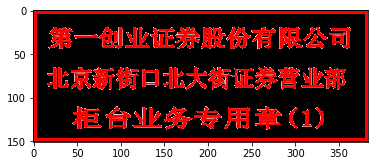

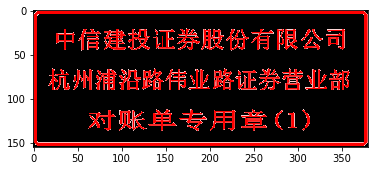

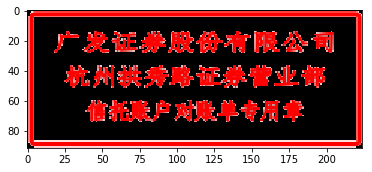

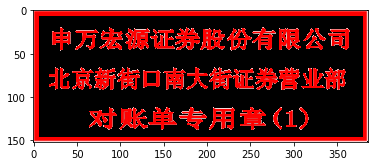

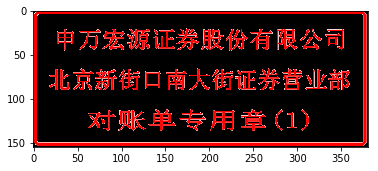

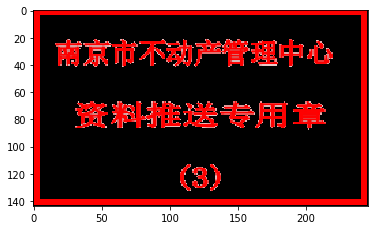

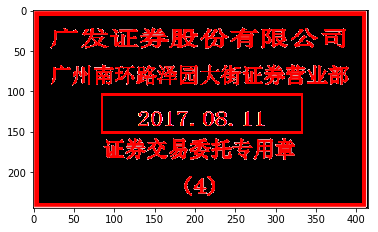

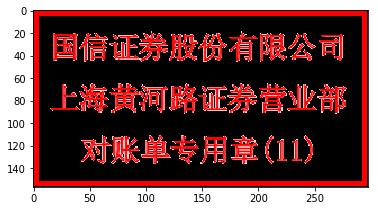

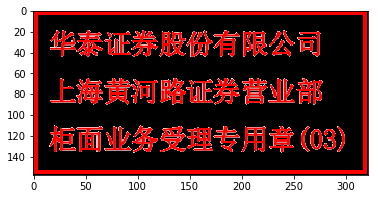

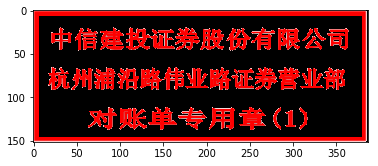

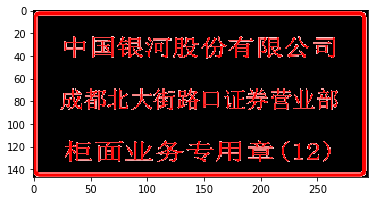

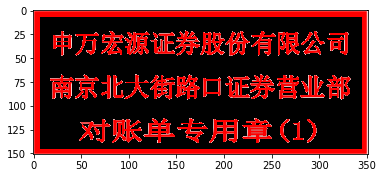

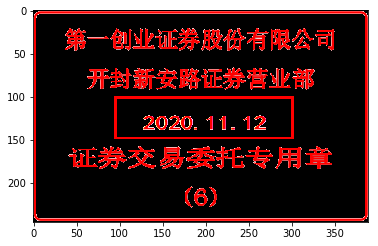

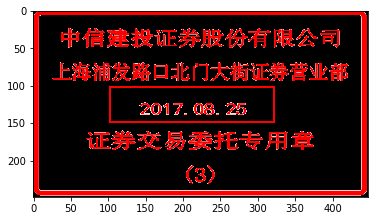

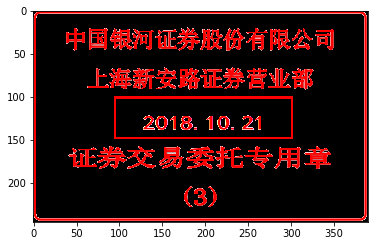

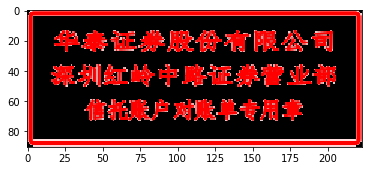

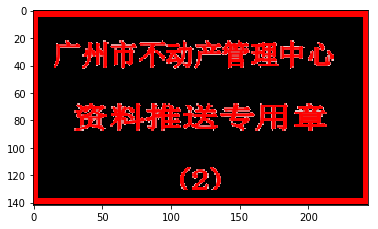

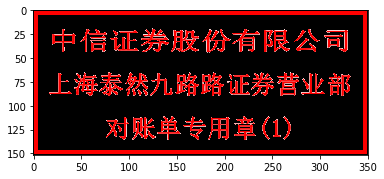

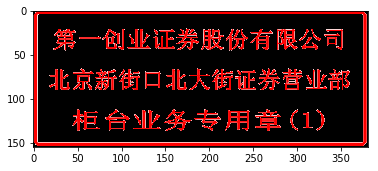

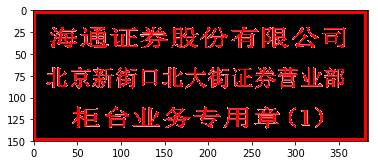

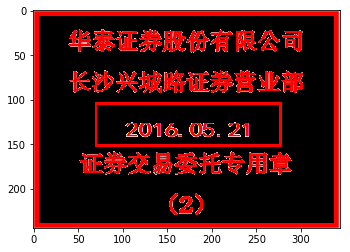

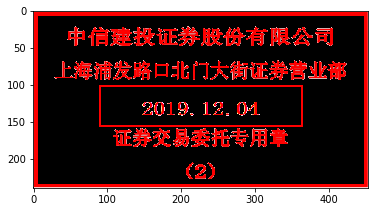

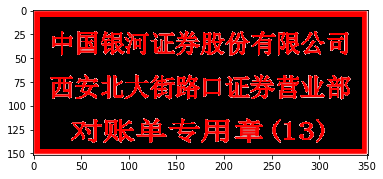

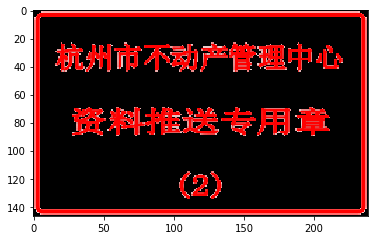

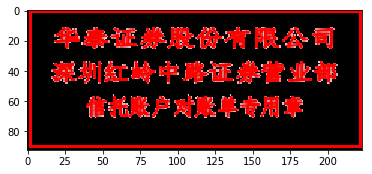

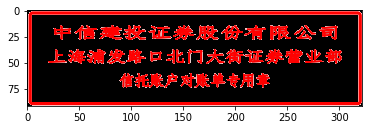

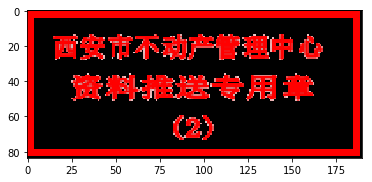

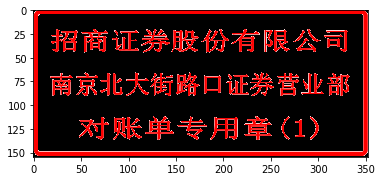

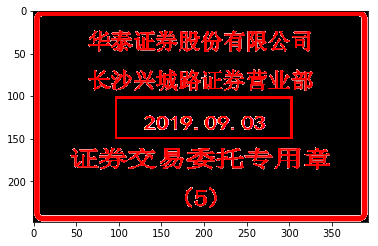

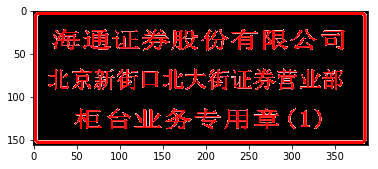

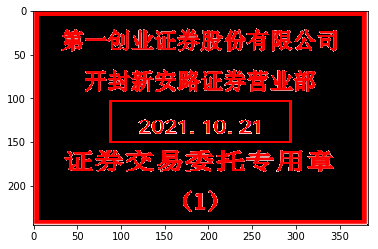

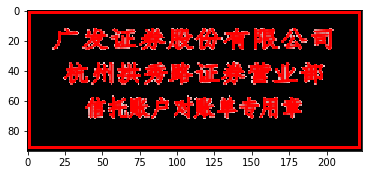

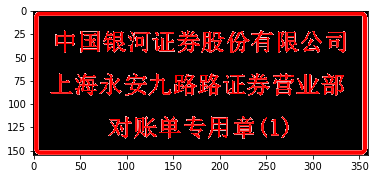

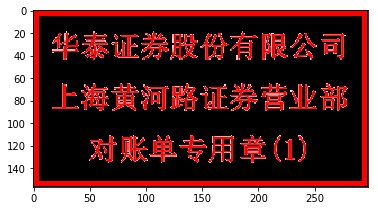

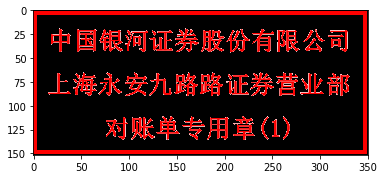

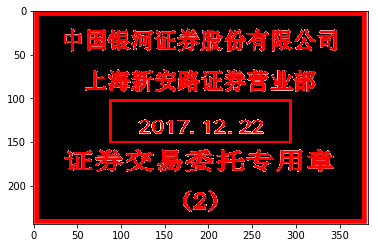

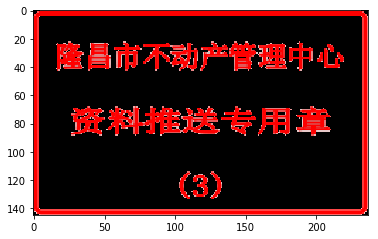

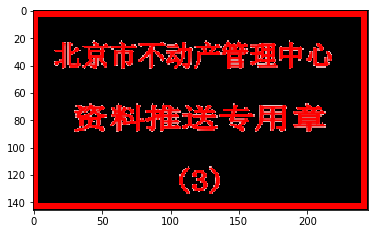

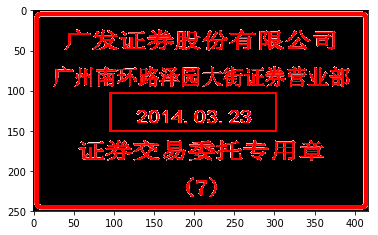

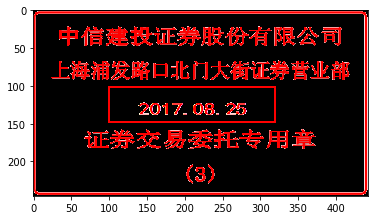

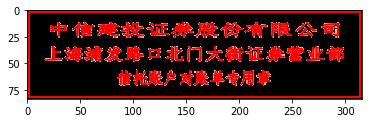

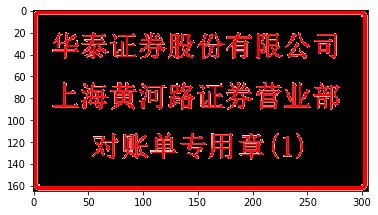

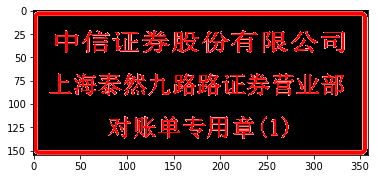

In [5]:
test_dir = os.path.join(os.getcwd(),'data', 'objects', 'rectangle_comany_name')
filenames = [filename for filename in os.listdir(test_dir) if filename[-3:] in ['jpg','png'] ]
filenames
for index in range(filenames.__len__()):

    img_path = os.path.join(test_dir,filenames[index])
    transparent_img = transparent_image_by_hsv(img_path,hMin=0,hMax=179)
    transparent_img_rgb = cv.cvtColor(transparent_img,cv.COLOR_BGR2RGB)
    plt.imshow(transparent_img_rgb)
    plt.show()

In [5]:
# img_path = os.path.join('object_detection_server', 'test_data', 'seal_data_real', 'untest_images', '3_5-bak.jpg')
# test_dir = os.path.join('data', 'test', 'guohui')
# filenames = [filename for filename in os.listdir(test_dir) if filename[-3:] in ['jpg','png'] ]

# for index in range(filenames.__len__()):
#     img_path = os.path.join(test_dir,filenames[index])
#     transparent_img = transparent_image_by_hsv(img_path,hMin=0,hMax=179)
#     transparent_img_rgb = cv.cvtColor(transparent_img,cv.COLOR_BGR2RGB)
#     plt.imshow(transparent_img_rgb)
#     plt.show()

#  旋转处理

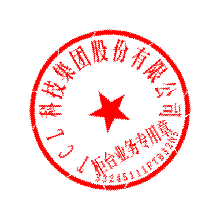

In [20]:
img_path = os.path.join(os.getcwd(),'data', 'objects', 'round_seal',
                         'TCL科技集团股份有限公司_www.395.net.cn_alpha.png')

# img_path = os.path.join(os.getcwd(),'data', 'objects', 'front_idcard',
#                          '1611900372351_3E31BECB-A011-4d23-8B40-383B20209E72.png')

rotate_angle = 30
img = Image.open(img_path)

img = img.convert('RGBA')

r_channel,g_channel,b_channel,alpha_channel = img.split()
# # # # 图片旋转 某个角度,图片在expand的时候会变大
img_rot = img.rotate(rotate_angle, expand=True)
# # # # 生成一个图片同样大小的 mask
# # alpha = Image.new('RGBA', img_rot.size, (255,) *4)
alpha_rot = alpha_channel.rotate(rotate_angle, expand=True)
# # np.array(alpha)
# # # # 使用alpha层的 rot作为掩码创建一个复合图像
out = Image.composite(img_rot,img_rot,alpha_rot)
out

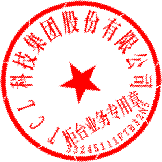

In [21]:
autoCrop(out,'seal')

# 合成图片


In [19]:
objects_dir = f'data/objects/'
backgrounds_dir = "data/backgrounds"

subobject_dir_names = os.listdir(objects_dir)
obj_image_dir_name =   'rectangle_company_seal' # subobject_dir_names[0]
subobject_dir = os.path.join(objects_dir,obj_image_dir_name )
print(subobject_dir)

object_names = os.listdir(subobject_dir)


object_path = os.path.join(subobject_dir, object_names[6])
obj_img = Image.open(object_path)
print(obj_img.mode)

background_names = os.listdir(backgrounds_dir)
background_path = os.path.join(backgrounds_dir, background_names[0])
bkg_img = Image.open(background_path)

boxes=[]


data/objects/rectangle_company_seal
RGBA


In [20]:
def object_resize(obj_img, obj_image_dir_name,rectangle_comany_name_resize_ratio=0.5):
    """
    身份证 = 85.6mm* 宽54mm
    :param obj_img:
    :param obj_image_dir_name:
    :return:
    """
    IDCARD_WIDTH = 8.56
    IDCARD_HEIGHT = 5.4
    inchesPerCentimeter = 0.393700787
    IDCARD_WIDTH_inch = IDCARD_WIDTH * inchesPerCentimeter
    IDCARD_HEIGHT_inch = IDCARD_HEIGHT * inchesPerCentimeter
    # print(obj_img.info)
    dpi = obj_img.info.get('dpi')
    if dpi is None:
        dpi = (96,96)

    # 对身份证做 resize 处理
    if obj_image_dir_name.split("_")[-1] == "idcard":
        size = (IDCARD_WIDTH_inch * dpi[0], IDCARD_HEIGHT_inch * dpi[1])
        size = (int(size[0]), int(size[1]))
        obj_img = obj_img.resize(size=size)
    elif obj_image_dir_name.split("_")[-1] == "qrcode":
        obj_img = obj_img.resize(size=(60, 60))
    elif obj_image_dir_name == "guohui":
        size = (IDCARD_WIDTH_inch *0.2* dpi[0], IDCARD_HEIGHT_inch * 0.35* dpi[1])
        size = (int(size[0]), int(size[1]))
        obj_img = obj_img.resize(size=size)
    elif obj_image_dir_name == 'rectangle_company_seal':
        size  = obj_img.size
        new_size = [int(s* rectangle_comany_name_resize_ratio) for s in size]
        obj_img = obj_img.resize(size = new_size)
    return obj_img

(207, 122)


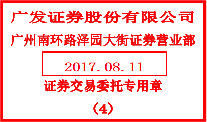

In [21]:
# 1. 调整大小:
obj_img = object_resize(obj_img,obj_image_dir_name)
print(obj_img.size)
obj_img

(213, 130)


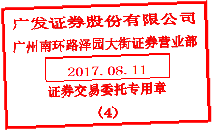

In [22]:
# 2. 进行旋转
img_rot = rotate_image(img=obj_img)
print(img_rot.size)
img_rot

In [23]:
# 3. 去除图形边缘
img_crop = autoCrop(img_rot)

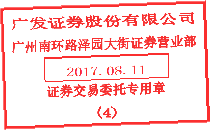

In [24]:
# 4. 图片增强
img_enhanced = enhance_image(img=img_crop)
img_enhanced

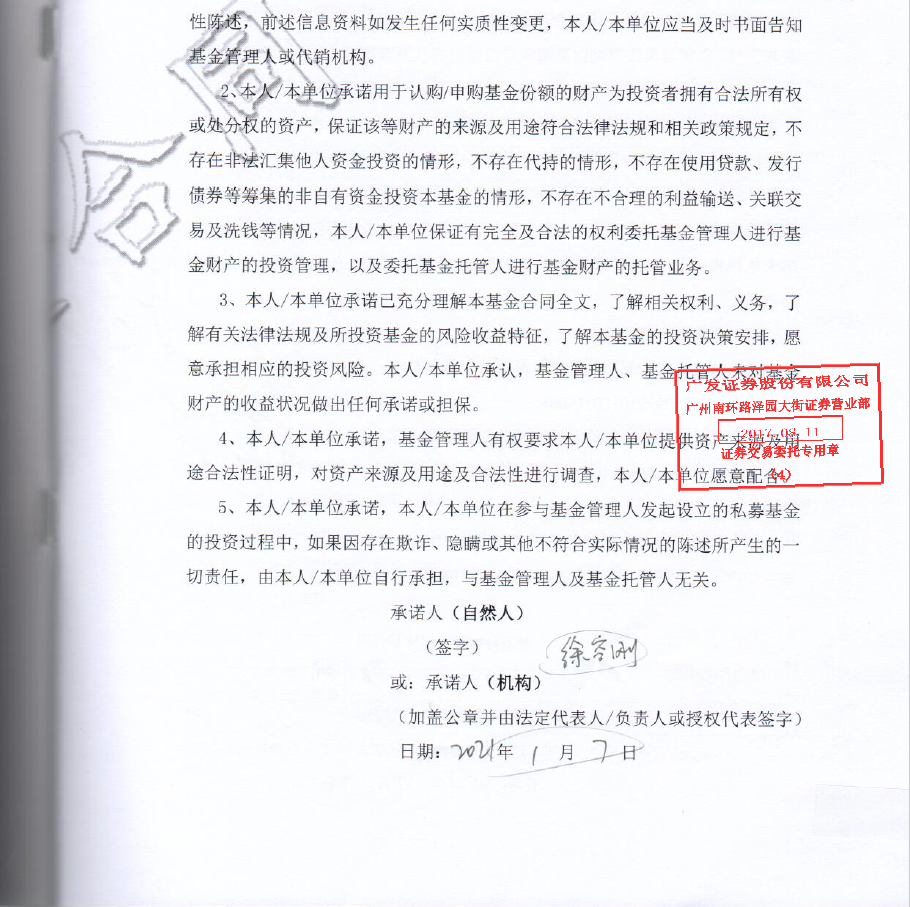

In [25]:
# 5. 获取 bbox 和图片增强
obj_h, obj_w, x_pos, y_pos = get_obj_positions(obj=img_enhanced, bkg=bkg_img, sizes=[1], count=1)

x = x_pos[0]
y = y_pos[0]
w = obj_w[0]
h = obj_h[0]
# 6. 获取 obj_bbox
obj_bbox = list([int(x), int(y), int(w), int(h)])
# 7. 合并图片 ： bkg_w_obj 作为 bkg_w 参数输入
bkg_w_obj = bkg_img.copy()
bkg_w_obj, obj_bbox = combine_background_and_object(bkg_w_obj, img_enhanced, obj_bbox)
bkg_w_obj

In [26]:
bkg_w_obj = bkg_img.copy()
bkg_w_obj, obj_bbox, new_box = synthesize_background_and_object(bkg_w_obj, bkg_img, obj_img, obj_image_dir_name,boxes)

bbox=[331, 209, 223, 152],text_label=rectangle_company_seal


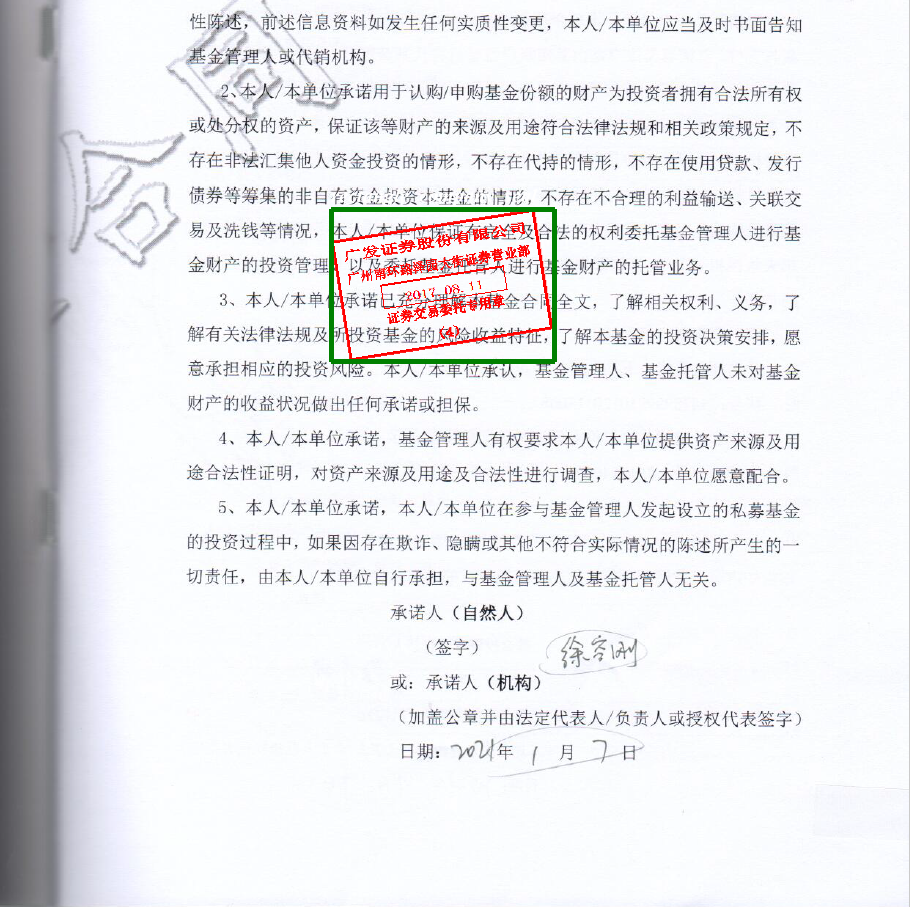

In [27]:
draw_bbox(img=bkg_w_obj, bboxes=[obj_bbox], labels=obj_image_dir_name)

In [ ]:
# from matplotlib.font_manager import fontManager

# for i in fontManager.ttflist:
#     print(i.fname, i.name)